In [6130]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image
import os

In [6131]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

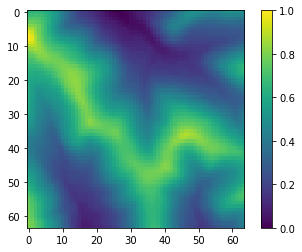

In [6132]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[6498].view(64, 64))
plt.colorbar(p)
plt.show()

In [6133]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8581]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(out_n, out_n, kernel_size=3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64)
        self.enc_cnn_3 = double_cnn(64, 96)
        self.enc_cnn_4 = double_cnn(96, 128)
        
        self.enc_linear_1_1 = nn.Linear(2048, 64)
        self.enc_linear_1_2 = nn.Linear(2048, 64)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(64, 2048)
        
        self.dec_cnn_1 = double_cnn(128, 96)
        self.dec_cnn_2 = double_cnn(96, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = self.enc_cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))

        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        out = F.leaky_relu(self.dec_linear_1(z))
        out = out.view(out.size(0), 128, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.leaky_relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.leaky_relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.leaky_relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparametrize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

In [8588]:
vae = VAE().cuda()

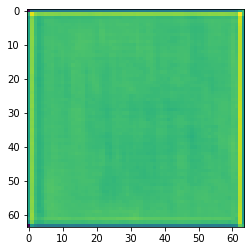

In [8589]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [8590]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD *= 0.1
    return MSE + KLD, MSE, KLD

optimizer = optim.Adam(vae.parameters(), lr=0.0001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    i = 0
    for data in dataloader:
        i += 1
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss, MSE, KLD = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            msg = "epoch[{}/{}], loss={:.3f}, MSE={:.3f}, KLD={:.3f}".format(epoch + 1, epochs, 
                  loss.item() / batch_size, MSE.item() / batch_size, KLD.item() / batch_size)
            print(msg)

epoch[1/100], loss=180.904, MSE=175.512, KLD=5.392
epoch[1/100], loss=79.326, MSE=72.773, KLD=6.553
epoch[1/100], loss=65.214, MSE=58.105, KLD=7.109
epoch[1/100], loss=55.052, MSE=48.248, KLD=6.804
epoch[1/100], loss=53.559, MSE=46.532, KLD=7.027
epoch[2/100], loss=42.788, MSE=35.515, KLD=7.273
epoch[2/100], loss=46.303, MSE=39.011, KLD=7.292
epoch[2/100], loss=40.612, MSE=33.647, KLD=6.964
epoch[2/100], loss=41.981, MSE=34.704, KLD=7.277
epoch[2/100], loss=35.314, MSE=28.344, KLD=6.970
epoch[3/100], loss=35.895, MSE=29.201, KLD=6.694
epoch[3/100], loss=38.136, MSE=31.145, KLD=6.991
epoch[3/100], loss=36.688, MSE=29.969, KLD=6.719
epoch[3/100], loss=32.301, MSE=25.685, KLD=6.616
epoch[3/100], loss=35.334, MSE=28.771, KLD=6.563
epoch[4/100], loss=34.787, MSE=28.216, KLD=6.571
epoch[4/100], loss=34.565, MSE=28.008, KLD=6.556
epoch[4/100], loss=34.495, MSE=27.970, KLD=6.526
epoch[4/100], loss=31.226, MSE=24.728, KLD=6.498
epoch[4/100], loss=32.558, MSE=25.817, KLD=6.740
epoch[5/100], loss

epoch[34/100], loss=21.627, MSE=15.453, KLD=6.174
epoch[34/100], loss=18.483, MSE=12.483, KLD=5.999
epoch[34/100], loss=18.933, MSE=12.880, KLD=6.054
epoch[34/100], loss=18.973, MSE=12.892, KLD=6.081
epoch[34/100], loss=19.285, MSE=13.269, KLD=6.016
epoch[35/100], loss=18.473, MSE=12.374, KLD=6.099
epoch[35/100], loss=18.372, MSE=12.399, KLD=5.974
epoch[35/100], loss=17.417, MSE=11.276, KLD=6.141
epoch[35/100], loss=18.937, MSE=12.744, KLD=6.193
epoch[35/100], loss=18.512, MSE=12.104, KLD=6.408
epoch[36/100], loss=19.356, MSE=13.037, KLD=6.318
epoch[36/100], loss=19.560, MSE=13.139, KLD=6.421
epoch[36/100], loss=18.871, MSE=12.731, KLD=6.140
epoch[36/100], loss=17.063, MSE=11.064, KLD=5.999
epoch[36/100], loss=20.777, MSE=14.481, KLD=6.296
epoch[37/100], loss=19.172, MSE=12.705, KLD=6.467
epoch[37/100], loss=18.543, MSE=12.435, KLD=6.108
epoch[37/100], loss=21.294, MSE=15.064, KLD=6.230
epoch[37/100], loss=18.689, MSE=12.403, KLD=6.286
epoch[37/100], loss=17.469, MSE=11.225, KLD=6.244


epoch[67/100], loss=16.811, MSE=10.360, KLD=6.452
epoch[67/100], loss=15.494, MSE=9.283, KLD=6.211
epoch[67/100], loss=18.429, MSE=11.593, KLD=6.837
epoch[67/100], loss=16.453, MSE=10.096, KLD=6.358
epoch[67/100], loss=17.026, MSE=10.515, KLD=6.512
epoch[68/100], loss=18.001, MSE=11.348, KLD=6.653
epoch[68/100], loss=16.333, MSE=9.991, KLD=6.342
epoch[68/100], loss=17.375, MSE=10.797, KLD=6.578
epoch[68/100], loss=16.614, MSE=10.053, KLD=6.561
epoch[68/100], loss=16.812, MSE=10.378, KLD=6.434
epoch[69/100], loss=17.279, MSE=10.676, KLD=6.602
epoch[69/100], loss=16.292, MSE=9.781, KLD=6.511
epoch[69/100], loss=17.770, MSE=11.025, KLD=6.744
epoch[69/100], loss=17.259, MSE=10.693, KLD=6.566
epoch[69/100], loss=16.599, MSE=10.267, KLD=6.333
epoch[70/100], loss=17.717, MSE=11.145, KLD=6.572
epoch[70/100], loss=16.306, MSE=9.867, KLD=6.439
epoch[70/100], loss=18.299, MSE=11.512, KLD=6.787
epoch[70/100], loss=16.279, MSE=9.642, KLD=6.637
epoch[70/100], loss=17.916, MSE=11.431, KLD=6.485
epoch

epoch[100/100], loss=17.686, MSE=10.992, KLD=6.694
epoch[100/100], loss=16.138, MSE=9.527, KLD=6.611
epoch[100/100], loss=17.395, MSE=10.488, KLD=6.906
epoch[100/100], loss=15.588, MSE=8.948, KLD=6.639


In [8591]:
torch.cuda.empty_cache()

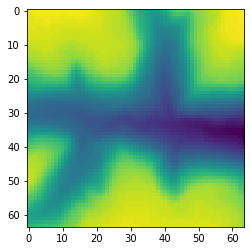

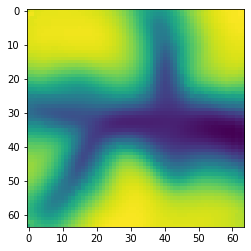

In [8592]:
x = dataset[5948].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [8732]:
#torch.save(vae.state_dict(), './vae_save')

In [7295]:
vae.load_state_dict(torch.load('./vae_save'))

<All keys matched successfully>

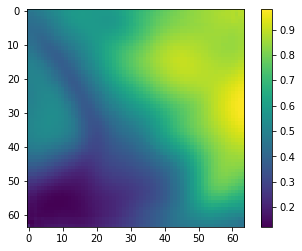

In [8905]:
# Generator
code = torch.FloatTensor(1, 64).normal_()

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()